# Capstone

## Research Question 1: Mortality Prediction in ICU 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately **predict mortality** based on data from the **first 24 hours in ICU**?

## Research Question 2: Weekend Effect in ICU 

Objective: To develop a statistical model to estimate the effect of **weekend admission to ICU** on the **risk of ICU mortality**. 

Question: Does admission to ICU over the weekend increase the risk of mortality? 

In [42]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [255]:
FILE_PATH = 'raw_data/'
FILE_EXTENSION = '.csv'

INPUT_DATA_DIR = 'input/input.csv'
STARTING_TABLES  = \
['pt_icu_outcome', 'vitals_hourly', 'labs_hourly', 'gcs_hourly', 'admissions']
FILE_DIR = [FILE_PATH + name + FILE_EXTENSION for name in STARTING_TABLES]

In [37]:
raw_icu = pd.read_csv(FILE_DIR[0])
raw_vitals = pd.read_csv(FILE_DIR[1])
raw_labs = pd.read_csv(FILE_DIR[2])
raw_gcs = pd.read_csv(FILE_DIR[3]) #Glasgow Coma Score
raw_ad = pd.read_csv(FILE_DIR[4])

In [69]:
raw_admission.query('subject_id==17').sort_values(by=['row_id'])

,row_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,prev_admittime,re_adm_in30d
subject_id,,,,,,,,,,,,,,,,,,,,
17,14,194023,2134-12-27,2134-12-31,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,0,1,NaT,False
17,15,161087,2135-05-09,2135-05-13,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,2135-05-09 11:27:00,2135-05-09 13:45:00,PERICARDIAL EFFUSION,0,1,133 days,False


In [242]:
#raw_admission.nunique(dropna=False)
adms_dt_cols = {'admittime', 'dischtime', 'deathtime',}
raw_ad.loc[:, adms_dt_cols] = \
raw_ad.loc[:, adms_dt_cols].apply(lambda x: pd.to_datetime(x).dt.date, axis=0)
raw_admission = raw_ad.sort_values(by=['subject_id', 'admittime']).\
set_index(['subject_id'])
raw_admission.loc[:, ('prev_admittime')] =\
raw_admission.groupby(level=0)['admittime'].diff()
#raw_admission.loc[:, ('prev_admittime')] = raw_admission.prev_admittime.dt.days
raw_admission.loc[:, ('re_adm_in30d')] = raw_admission.prev_admittime.dt.days <= 30
raw_admission.loc[:, ('len_of_adm')] = \
    (raw_admission.dischtime - raw_admission.admittime).dt.days
raw_admission.loc[:, ('english_speaker')] = \
raw_admission.groupby(level=0)['language'].apply(lambda x: 'ENGL' in list(x))
raw_admission.loc[:, ('admission_type')] = raw_admission.loc[:, ('admission_type')].\
    apply(lambda x: x.replace(' ', '').lower())
raw_admission.loc[:, ('insurance')] = raw_admission.loc[:, ('insurance')].\
    apply(lambda x: x.replace(' ', '').lower())
adm_dummies = pd.get_dummies(raw_admission, 
                             columns = ['insurance','admission_type'],
                             prefix=['insure','adm_type'])
cols_to_keep_admission = ('hadm_id','len_of_adm','re_adm_in30d','english_speaker',
                          'insure_government','insure_medicaid','insure_medicare',
                          'insure_private','insure_selfpay','adm_type_elective',
                          'adm_type_emergency','adm_type_newborn','adm_type_urgent')
admission_cleaned = adm_dummies.reset_index().loc[:, cols_to_keep_admission]

In [152]:
raw_vitals_condition = \
((raw_vitals.spo2<0)|(raw_vitals.spo2>100))| \
(\
 (raw_vitals.temperature<0)|(raw_vitals.temperature>108)|\
 ((raw_vitals.temperature>45)&(raw_vitals.temperature<96))\
)| \
((raw_vitals.resprate<0)|(raw_vitals.resprate>196))| \
((raw_vitals.heartrate<0)|(raw_vitals.heartrate>480)) | \
((raw_vitals.sysbp<0)|(raw_vitals.sysbp>300))| \
((raw_vitals.diasbp<0)|(raw_vitals.diasbp>250)) | \
((raw_vitals.glucose<0)|(raw_vitals.glucose>1500))| \
((raw_vitals.meanarterialpressure<0)|(raw_vitals.meanarterialpressure>400))

raw_vitals_condition = \
((raw_vitals.spo2<0)|(raw_vitals.spo2>100))| \
(\
 (raw_vitals.temperature<0)|(raw_vitals.temperature>108)|\
 ((raw_vitals.temperature>45)&(raw_vitals.temperature<96))\
)| \
((raw_vitals.resprate<0)|(raw_vitals.resprate>196))| \
((raw_vitals.heartrate<0)|(raw_vitals.heartrate>480)) | \
((raw_vitals.sysbp<0)|(raw_vitals.sysbp>300))| \
((raw_vitals.diasbp<0)|(raw_vitals.diasbp>250)) | \
((raw_vitals.glucose<0)|(raw_vitals.glucose>1500))| \
((raw_vitals.meanarterialpressure<0)|(raw_vitals.meanarterialpressure>400))

In [153]:
first_24_vital = raw_vitals[~raw_vitals_condition].query('hr>0 and hr<=24') #bedside measurements, no pre-ICU data
first_24_labs = raw_labs.query('hr>0 and hr<=24') #blood tests, negative hours=pre-ICU
first_24_gcs = raw_gcs.query('hr>0 and hr<=24') #conscuousness

In [154]:
raw_vitals.describe()

,icustay_id,hr,spo2,fio2,temperature,resprate,heartrate,sysbp,diasbp,glucose,meanarterialpressure
count,7292362.0000,7292362.0000,5319977.0000,950397.0000,1565924.0000,4742189.0000,6420350.0000,4644472.0000,4643694.0000,1148019.0000,4660544.0000
mean,250001.8002,285.4975,93.3514,50.4574,37.0183,20.4126,103.2994,121.9935,61.2899,142.2999,79.3858
std,28683.9642,444.0433,3143.4318,28.7282,3.0048,540.8859,48.4280,132.0296,237.0564,1320.9061,97.5509
min,200001.0000,1.0000,-34.0000,21.0000,-73.2778,0.0000,-88.0000,-69.0000,-4.0000,0.1060,-36.0000
25%,225161.0000,35.0000,96.0000,27.0000,36.5000,16.0000,78.0000,105.0000,51.0000,107.0000,68.0000
50%,250192.0000,109.0000,98.0000,40.0000,37.0000,20.0000,93.0000,119.0000,59.0000,129.0000,77.0000
75%,274800.0000,331.0000,99.0000,65.0000,37.5556,24.0000,127.0000,136.0000,69.0000,159.0000,88.0000
max,299999.0000,4154.0000,6363333.0000,100.0000,2686.3056,1177786.5000,86101.0000,141146.0400,114108.9800,999999.0000,120130.0300


In [155]:
#utility function
def dataset_brief(df, name):
    print('Dataset {2} provided of size:\t{0:1d} rows and {1:1d} columns\n'.\
      format(df.shape[0], df.shape[1], name))
    print('List of columns in the dataset:')
    print(df.columns.tolist())
    print('missing values:')
    print((df.isnull().sum()).sort_values(ascending=False))
    print('missing values in perc%:')
    print((df.isnull().sum()/df.shape[0]).sort_values(ascending=False))
    for column in df.columns:
        print('Column {0} has {1:1d} unique numbers including NA or {2:1d} unique numbers excl. NA'.\
              format(column, 
                     df[column].nunique(dropna=False),
                     df[column].nunique(dropna=True)))

def get_dow_name(df, col_name):
    return pd.to_datetime(df.loc[:,(col_name)]).dt.day_name()

def my_odds_and_risks(df):
    n = df.shape[0]
    v = range(n)
    for rows in [[a,b] for a in v for b in v if a != b]:
        print(list(df.index[rows]))
        #print(df.iloc[rows,:])
        b, a, d, c = np.ravel(df.iloc[rows,:].to_numpy())
        print('OR/RR : {0:.2f} / {1:.2f}'.format((a/c)/(b/d), df.iloc[rows,-1].values[0]/df.iloc[rows,-1].values[1]))

In [230]:
#ETL - ICU PT
#drop duplicates, exclude rows without icu admission time
raw_pt_icu = raw_icu.query('intime.notnull() and outtime.notnull() and icustay_id!=229922 and (ttd_days >=0 or ttd_days.isnull())')
raw_pt_icu.loc[:, ('age_bins')] =\
pd.cut(raw_pt_icu.age_years, \
       [-math.inf,20,40,60,80,math.inf], \
       labels =['under20','20-40', '40-60','60-80', 'over80'])
#get day of the week of ICU admission time
raw_pt_icu.loc[:,('intime_weekday')] = get_dow_name(raw_pt_icu, 'intime')
WKN = {'Saturday', 'Sunday'}
#recognise weekend shifts
raw_pt_icu.loc[:,('icu_adm_weekend')] = [True if x in WKN else False for x in raw_pt_icu.intime_weekday]
datetime_cols = {'dob', 'admittime', 'dischtime', 'intime', 'outtime', 
                 'hosp_deathtime', 'dod',}
raw_pt_icu.loc[:, datetime_cols] = raw_pt_icu.loc[:, datetime_cols].apply(lambda x: pd.to_datetime(x).dt.date, axis=0)
raw_pt_icu.loc[:, 'ttd_bins'] = pd.cut(raw_pt_icu.ttd_days.values, bins=[-math.inf,7,14,30, math.inf])
#death in 7 days (ttd < 7) to create mortality label
LABEL = 'standard_mortality_label'
raw_pt_icu.loc[:, (LABEL)] = raw_pt_icu['ttd_days'] < 7
pt_icu_cleaned = pd.get_dummies(raw_pt_icu, columns=['age_bins','intime_weekday'])

In [158]:
#ETL - Vital
first_24_vital.loc[first_24_vital.temperature > 43, ('temperature')] = \
first_24_vital.query('temperature > 43').temperature.apply(lambda x: (x-32)*5/9)
first_24_vital.loc[:, ('sys_bp_category')] =\
pd.cut(first_24_vital.sysbp, [-math.inf, 120, 129, 139, 180, math.inf], \
       labels=('normal','elevated','HBP-stg1', 'HBP-stg2', 'HBP-Crisis'))
first_24_vital.loc[:, ('dias_bp_category')] =\
pd.cut(first_24_vital.diasbp, [-math.inf, 80, 89, 120, math.inf], \
       labels=('normal','HBP-stg1', 'HBP-stg2', 'HBP-Crisis'))
first_24_vital.loc[:, ('bp_elevated')] =\
    (first_24_vital.sys_bp_category=='elevated') & (first_24_vital.dias_bp_category=='normal')
first_24_vital.loc[:, ('bp_hbp_s1')] =\
    (first_24_vital.sys_bp_category=='HBP-stg1') | (first_24_vital.dias_bp_category=='HBP-stg1')
first_24_vital.loc[:, ('bp_hbp_s2')] =\
    (first_24_vital.sys_bp_category=='HBP-stg2') | (first_24_vital.dias_bp_category=='HBP-stg2')
first_24_vital.loc[:, ('bp_hyptsn_crisis')] =\
    (first_24_vital.sys_bp_category=='HBP-Crisis') | (first_24_vital.dias_bp_category=='HBP-Crisis')

first_24_vital = \
first_24_vital.assign(
    abnorm_spo2 = lambda x: x.spo2 < 95, # spo2 below 95 -> high risk of hypoxemia
    fever = lambda x: x.temperature > 38, # over 38C =fever   
    tachycardia = lambda x: x.heartrate > 100, #tachycardia
    bradycardia = lambda x: x.heartrate < 60,# bradycardia
    diabetes = lambda x: x.glucose >199, #assume rancdom plasma glucose test
    abnorm_map = lambda x: (x.meanarterialpressure > 100)|(x.meanarterialpressure < 60),
    #for doctors to checkjj blood flow, resistance and pressure to supply bloody to major organs
)
first_24_vital_agg = \
first_24_vital.loc[:, ('icustay_id', 'bp_elevated', 'bp_hbp_s1', 'bp_hbp_s2', 
                       'bp_hyptsn_crisis','abnorm_spo2', 'fever', 'tachycardia',
                       'bradycardia', 'diabetes', 'abnorm_map')].\
set_index('icustay_id').groupby(level=0).apply(sum)

In [159]:
#ETL - GCS
first_24_gcs.loc[:, ('gcs_category')] = \
pd.cut(raw_gcs.gcs, [0,8,12,math.inf], labels=['severe','moderate','mild'])
first_24_gcs.loc[:, ('eye_no_resp')] = first_24_gcs.gcseyes == 1.0
first_24_gcs.loc[:, ('motor_no_resp')] = first_24_gcs.gcsmotor == 1.0
first_24_gcs.loc[:, ('verbal_no_resp')] = first_24_gcs.gcsverbal == 1.0
first_24_gcs.loc[:, ('gcs_severe')] = first_24_gcs.gcs_category == 'severe'
first_24_gcs.loc[:, ('gcs_moderate')] = first_24_gcs.gcs_category == 'moderate'

first_24_gcs_agg = \
first_24_gcs.loc[:, ('icustay_id', 'endotrachflag', 'eye_no_resp', 'motor_no_resp',
                     'verbal_no_resp', 'gcs_severe', 'gcs_moderate')].\
set_index('icustay_id').groupby(level=0).apply(sum)

In [160]:
#ETL - Labs
# 'glucose', #diabetes
# 'bilirubin','alaninetransaminase', 'aspartatetransaminase', #Hepatocytedamage #acute hepatitis
# 'chloride', 'sodium', #electrolites
# 'creatinine', 'albumin','bloodureanitrogen', #kidney functionality
# 'hemoglobin', 'hematocrit', #anaemia
# 'whitebloodcell',  'platelets' , #leukemia
first_24_labs = \
first_24_labs.assign(
    abnorm_bicarbonate = lambda x: (x.bicarbonate<23)|(x.bicarbonate>29), 
    abnorm_albumin = lambda x: (x.albumin<3.5)|(x.albumin>5), 
    abnorm_troponin = lambda x: (x.troponin>0.4),
    abnorm_bloodureanitrogen = lambda x: (x.bloodureanitrogen<7)|(x.bloodureanitrogen>20), 
    abnorm_partialpressureo2 = lambda x: (x.partialpressureo2<75)|(x.partialpressureo2>100),
    abnorm_bilirubin = lambda x: (x.bilirubin<0.1)|(x.bilirubin>1.0),
    abnorm_alt = lambda x: (x.alaninetransaminase<7)|(x.alaninetransaminase>56),
    abnorm_ast = lambda x: (x.aspartatetransaminase<5)|(x.aspartatetransaminase>40),
    abnorm_hemoglobin = lambda x: (x.hemoglobin<116)|(x.hemoglobin>166),
    abnorm_hematocrit = lambda x: (x.hematocrit<35.5)|(x.hematocrit>48.6),
    abnorm_wbc = lambda x: (x.whitebloodcell<3.4)|(x.whitebloodcell>9.6),
    abnorm_platelets = lambda x: (x.platelets<135)|(x.platelets>371),
    abnorm_sodium = lambda x: (x.sodium<135)|(x.sodium>145),
    abnorm_chloride = lambda x: (x.chloride<95)|(x.chloride>110),
    abnorm_creatinine = lambda x: (x.creatinine<0.6)|(x.creatinine>1.3),
    abnorm_glucose = lambda x: (x.glucose>199),
    abnorm_neutrophil = lambda x: (x.neutrophil<45)|(x.neutrophil>75), 
    abnorm_creactiveprotein = lambda x: (x.creactiveprotein>10),
    abnorm_lactate = lambda x: (x.lactate>1.0),
    abnorm_inr = lambda x: (x.intnormalisedratio<2)|(x.intnormalisedratio>3),
)
first_24_labs_agg = \
first_24_labs.loc[:,\
                   ('icustay_id', 'abnorm_albumin', 'abnorm_bilirubin', 'abnorm_alt',
                    'abnorm_ast', 'abnorm_hemoglobin', 'abnorm_hematocrit', 'abnorm_wbc',
                    'abnorm_platelets', 'abnorm_sodium', 'abnorm_chloride',
                    'abnorm_bicarbonate', 'abnorm_troponin', 'abnorm_bloodureanitrogen',
                    'abnorm_partialpressureo2', 'abnorm_creatinine', 'abnorm_glucose',
                    'abnorm_neutrophil', 'abnorm_creactiveprotein', 'abnorm_lactate','abnorm_inr')].\
set_index('icustay_id').groupby(level=0).apply(sum)

In [239]:
admission_cleaned.columns

Index(['subject_id', 'hadm_id', 'len_of_adm', 're_adm_in30d',
       'english_speaker', 'insure_government', 'insure_medicaid',
       'insure_medicare', 'insure_private', 'insure_selfpay',
       'adm_type_elective', 'adm_type_emergency', 'adm_type_newborn',
       'adm_type_urgent'],
      dtype='object')

In [243]:
icu_n_admission = pd.merge(pt_icu_cleaned, admission_cleaned, how='inner', on='hadm_id')
icu_n_vital = pd.merge(icu_n_admission, first_24_vital_agg, how='inner', left_on='icustay_id',right_on='icustay_id')
icu_n_gcs = pd.merge(icu_n_vital, first_24_gcs_agg, how='inner', left_on='icustay_id',right_on='icustay_id')
icu_n_labs = pd.merge(icu_n_gcs, first_24_labs_agg, how='inner', left_on='icustay_id',right_on='icustay_id')

In [246]:
cols_to_drop_final = \
['row_id', 'dob', 'hadm_id', 'subject_id', 'admittime', 'dischtime',
 'icustay_id', 'age_years', 'intime', 'outtime','hosp_deathtime',
 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag',
 'ttd_days', 'icu_adm_weekend', 'ttd_bins']
pt_icu_final = icu_n_labs.drop(cols_to_drop_final, axis=1)

In [257]:
pt_icu_final.to_pickle("input/input.pkl")

In [258]:
#pd.read_pickle("input/input.pkl")

,los,standard_mortality_label,age_bins_under20,age_bins_20-40,age_bins_40-60,age_bins_60-80,age_bins_over80,intime_weekday_Friday,intime_weekday_Monday,intime_weekday_Saturday,...,abnorm_bicarbonate,abnorm_troponin,abnorm_bloodureanitrogen,abnorm_partialpressureo2,abnorm_creatinine,abnorm_glucose,abnorm_neutrophil,abnorm_creactiveprotein,abnorm_lactate,abnorm_inr
0,6.0646,False,0,0,0,1,0,0,0,0,...,3,0,1,6,1,4,1,0,4,1
1,1.6785,False,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1
2,3.6729,False,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,2
3,5.3231,True,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,3,0
4,1.5844,False,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51060,11.2998,False,0,0,1,0,0,0,1,0,...,1,0,0,4,0,0,1,0,1,1
51061,3.1426,False,0,0,1,0,0,0,0,0,...,2,0,1,1,0,0,1,0,1,1
51062,1.9745,False,0,0,0,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
51063,2.1615,False,0,0,0,0,1,0,0,0,...,2,0,0,4,2,0,0,0,0,2


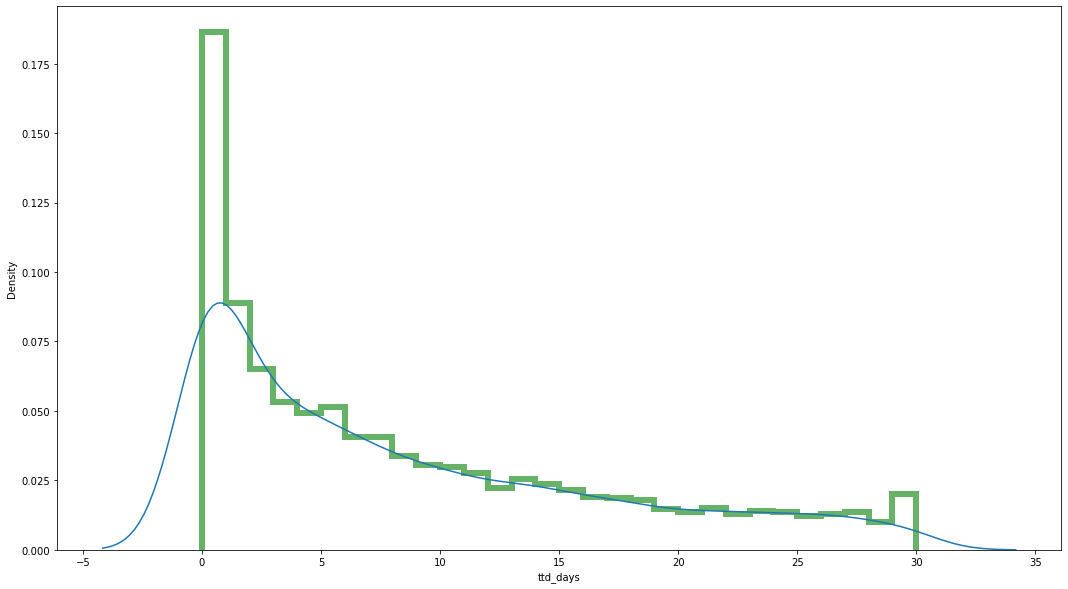

In [209]:
plt.figure(figsize=(18, 10))
sns.distplot(raw_pt_icu.query('ttd_days>=0 and ttd_days <=30').ttd_days, bins=30, hist=True, kde=True,rug=False,
    hist_kws={"density":True, "histtype": "step", "linewidth": 6, "alpha": 0.6, "color": "g"})

In [135]:
test = pd.crosstab(raw_pt_icu.icu_adm_weekend, 
                   raw_pt_icu.icu_expire_flag,
                   normalize='index')
my_odds_and_risks(test)

[False, True]
OR/RR : 0.90 / 0.90
[True, False]
OR/RR : 1.11 / 1.11


In [142]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
# table = pd.crosstab(label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"').relationship_grouped, label_n_client.query('relationship_grouped!="Other" and relationship_to_client!="someone_else"')
#                     .shared_need).to_numpy()
table = test
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

icu_expire_flag         0         1
icu_adm_weekend                    
False            0.995409  0.004591
True             0.994925  0.005075
dof=1
[[0.99516724 0.00483276]
 [0.99516724 0.00483276]]
probability=0.950, critical=3.841, stat=103.862
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [131]:
pd.crosstab(raw_pt_icu.icu_adm_weekend, raw_pt_icu.icu_expire_flag, normalize=True, )
#.\
#sort_index(ascending=False).T.sort_index(ascending=False).T

icu_expire_flag,0,1
icu_adm_weekend,,
False,0.775426,0.003576
True,0.219876,0.001122


In [334]:
lab24agg = first_24_labs.groupby('icustay_id').\
agg({'hr':['count'],
     #'neutrophil': ['median'],
     #'creactiveprotein': ['median'],
     'whitebloodcell': ['median'],
     'bicarbonate': ['median'],
     #'lactate': ['mean'],
     #'troponin': ['median'],
     'bloodureanitrogen': ['median'],
     'creatinine': ['median'],
     #'alaninetransaminase': ['median'],
     #'aspartatetransaminase': ['median'],
     'hemoglobin': ['median'],
     'platelets': ['median'],
     #'albumin': ['median'],
     'chloride': ['median'],
     'glucose': ['median'],
     #'bilirubin': ['median'],
     'hematocrit': ['median']}).T.reset_index().T
lab24agg.columns = lab24agg.apply(lambda x: '_'.join([x['level_0'], x['level_1']]), axis=0)
lab24agg_f = (lab24agg.iloc[2:,:].dropna())

In [347]:
bedside24agg = first_24_vital.groupby('icustay_id').\
agg({'hr':['count'],
     'spo2': ['min', 'max'], #reading of pulse ximeter (normal range 95-100%)
     #'fio2': ['median', 'max'],
     'temperature': ['min', 'max'], #normal temperature [36,38)
     #'resprate': ['median'], #respiratary rate
     'heartrate': ['min', 'max'], # > 100bpm or < 60bpm
     'sysbp': ['median'], #systolic blood pressure hypertensive crisis > 180
     'diasbp': ['median'], #diastolic blood pressure: hypertensive crisis > 120
     'meanarterialpressure': ['median'],}).T.reset_index().T
bedside24agg.columns = bedside24agg.apply(lambda x: '_'.join([x['level_0'], x['level_1']]), axis=0)
bedside24agg_f = bedside24agg.iloc[2:,:]#.dropna()